## Test cases for wave problems (2D)

### Wave problems

In this notebook, "wave problems" will be solved. This problems correspond to solutions of the Helmholtz equation

\begin{equation}
    \nablaˆ2 \phi + kˆ2 \phi = Q + \phi_{inc}
\end{equation}
where $\phi$ is the velocity potential such that $\nabla \cdot \phi = i \omega \rho p$, $p$ is the acoustic pressure, $\rho$ is the density, $k=\omega / c$ is the wave number for frequency $\omega$ , speed of propagation $c$, acoustic sources $Q$ and incident waves $\phi_{inc}$. $\nabla = \left( \frac{\partial}{\partial x}, \frac{\partial}{\partial y},\frac{\partial}{\partial z} \right)$ is the gradient operator and $\nablaˆ2 = \left( \frac{\partialˆ2}{\partial xˆ2} + \frac{\partialˆ2}{\partial yˆ2} + \frac{\partialˆ2}{\partial zˆ2} \right)$ is the Laplace operator.

### Constant elements

This examples uses BEM_base to solve the Helmholtz and Laplace equations in bidimensional space using polynomial shape functions and NURBS curves to describe the boundary and interpolate domain variables (velocity potential and its flux for the Helmholtz equation and temperature and its flux for the Laplace equation). The first example which will be solved is acoustic duct problem, which has an analytical solution. If both ends of the acoustic duct are closed, then a Neumann boundary condition ($q = \bar{q}$) is applied. Let the boundary condition of the wall in one of the extremities not be null and that extremity will act as a piston. The analytical resonance frequencies for such ducts are given by
\begin{equation}
    F_{closed\ duct}\ (n,L) = \frac{\pi\ n\ c}{L}
\end{equation}
where $c$ is the wave propagation speed, $n=0,1,2,...$ is the mode number and $L$ is the length of the duct. The frequency is in rad/s, divide it to $2\ pi$ to obtain the frequency in Hz. The duct which will be studied has length = 100 mm and diameter = 10 mm. The speed of sound is $c = 343$ m/s and only the first non-zero mode will be studied ($n=1$).


In [ ]:
Pkg.add("Mocha.jl")

In [12]:
c = 343*1000 # Speed of propagation in mm/s
F_closed(n,L,c) = pi*n*c/L # Analytical resonance frequency in rad/s
for n=1:5
    println("Mode n = $(n), L = $(L=100) mm, F = $(F_closed(n,L,c)/(2*pi)) Hz.")
end

To solve this problem using constant bidimensional elements, the geometry must be described to BEM_base. Initially, the module for the constant bidimensional element will be loaded.

In [13]:
# First, include the module const2D
include("../src/const2D/const2D.jl")
using const2D

Mode n = 1, L = 100 mm, F = 1715.0 Hz.
Mode n = 2, L = 100 mm, F = 3430.0 Hz.
Mode n = 3, L = 100 mm, F = 5145.0 Hz.
Mode n = 4, L = 100 mm, F = 6860.0 Hz.
Mode n = 5, L = 100 mm, F = 8575.0 Hz.


In [14]:
## Now, to define a new geometry, first one must declare the points,
# segments, boundary conditions, etc...
n = 5; # Mode number
L = 100; # Length of the duct in mm
d = 100; # Diameter of the duct in mm
c = 343*1000; # Speed of wave propagation in mm/s
k = F_closed(n,L,c)/c; # Resonance wave number
points = [1 0 0; 2 L 0; 3 L d; 4 0 d];
segments = [1 1 2 0; 2 2 3 0; 3 3 4 0; 4 4 1 0];
ne = 10; # Number of element per segment
MESH = [1 2*ne; 2 ne; 3 2*ne; 4 ne];
BCFace = [1 1 0; 2 1 0; 3 1 0; 4 0 1]; # Face 4 will act like a piston
fc = [0];
# Apply the discretization technique and builds the problems matrices
#for the geometrical points, physical nodes, elements' connectivity and
#boundary conditions
info = const2D.format_dad(points,segments,MESH,BCFace);
NOS_GEO,NOS,ELEM,CDC,normal = info;
# Now, the domain points will be created
#n_pdom = 100
#PONTOS_dom = zeros(n_pdom,3)
#for i = 1:n_pdom
#	PONTOS_dom[i,:] = [i ((100-0.1)/n_pdom)*i d/2]
#end
NPX = 30;
NPY = 30;
PONTOS_DOM=const2D.gera_p_in(NPX,NPY,points,segments); # generate domain points
n_pdom = size(PONTOS_DOM,1);
PONTOS_dom = zeros(n_pdom,3);
PONTOS_dom[:,2:3] = PONTOS_DOM[:,:];
for i = 1:n_pdom
    PONTOS_dom[i,1] = i;
end
u,q,udom,qdom = const2D.solve(info,PONTOS_dom,fc,BCFace,k);
#uH,qH,uintH,qintH = solveH(info,PONTOS_int,fc,BCFace,k);


Building A and b matrices using the traditional colocation BEM for constant elements.
  1.037933 seconds (617.40 k allocations: 13.921 MiB, 6.92% gc time)
Evaluating at domain points.
 

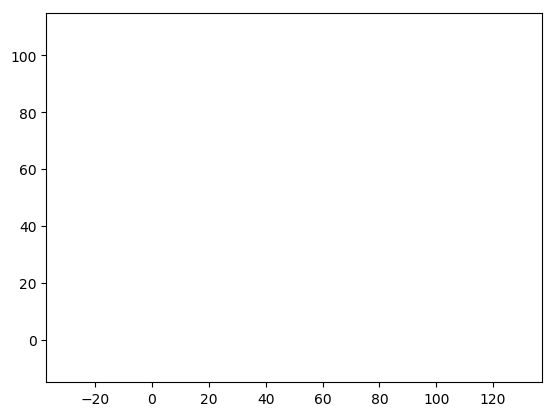

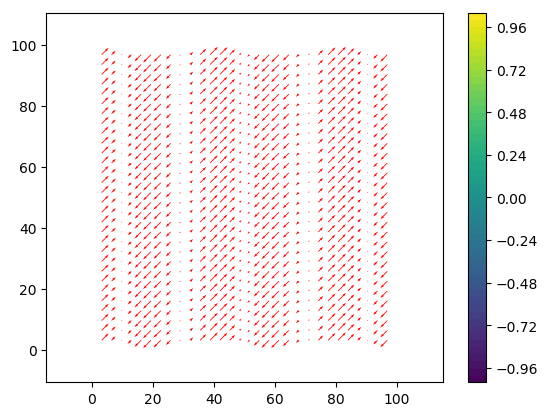

 3.185837 seconds (8.11 M allocations: 161.375 MiB, 13.81% gc time)


In [15]:
tipoCDC = zeros(Bool,size(CDC,1));
tipoCDC[:] = CDC[:,2];
valorCDC = CDC[:,3];
const2D.mostra_problema(ELEM[:,2:3],NOS_GEO[:,2:3],NOS[:,2:3],tipoCDC,valorCDC,normal,real.(u),real.(q))
const2D.mostra_heatmap(NOS[:,2:3],PONTOS_dom[:,2:3],real.(u),real.(udom),NOS_GEO[:,2:3],ELEM[:,2:3],real.(udom),real.(qdom));

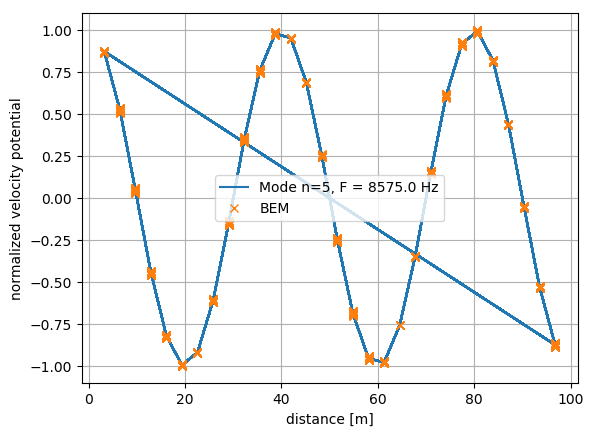

In [16]:
# Comparing the results
phi_closed(x,n,L,c) = cos.(n*pi*(x./L))
const2D.plt.figure()
const2D.plt.plot(PONTOS_dom[:,2],phi_closed(PONTOS_dom[:,2],n,L,c),label="Mode n=$(n), F = $(F_closed(n,L,c)/(2*pi)) Hz")
const2D.plt.hold(1)
const2D.plt.plot(PONTOS_dom[:,2],real.(udom),label="BEM",marker="x",linestyle="none")
#plot(PONTOS_int[:,2],real.(uintH),label="H-BEM",marker="<")

const2D.plt.legend()
const2D.plt.xlabel("distance [m]")
const2D.plt.ylabel("normalized velocity potential")
const2D.plt.grid(1)
const2D.plt.hold(0)

### Linear elements

### Linear discontinuous elements

### Quadratic discontinuous elements

### NURBS elements

In [17]:
# First, include the module const2D
include("../src/nurbs2D/nurbs2D.jl")
using nurbs2D

In [18]:
# Characteristics of the problem: Square domain with imposed temperature in two opposite faces and imposed null temperature flux at the other two faces. 
F_closed(n,L,c) = pi*n*c/L # Analytical resonance frequency in rad/s
phi_closed(x,n,L,c) = cos.(n*pi*(x./L)) # Acoustic pressure distribution along the duct
c = 343*1000; # Speed of wave propagation in mm/s
n = 3; # Mode number
L = 100; # Length of the duct in mm
d = 100; # Diameter of the duct in mm

In [19]:
# Acoustic duct problem
points = [1 0 0; 2 L 0; 3 L d; 4 0 d];
segments = [1 1 2 0; 2 2 3 0; 3 3 4 0; 4 4 1 0];
ne = 10; # Number of element per segment
MESH = [1 ne; 2 ne; 3 ne; 4 ne];
BCFace = [1 1 0; 2 1 0; 3 1 0; 4 0 -1]; # Face 4 will act like a piston

  # Gerando a curva NURBS
  crv = nurbs2D.format_dad_iso(points,segments,MESH)
  dcrv=map(x->nurbs2D.nrbderiv(x),crv)
  n = length(crv);	# N�mero total de elementos
  p=1;#refinamento p
  for i=1:n
      degree=crv[i].order-1
      #	println(crv[i].knots)
      #	println(crv[i].coefs)
      coefs,knots = nurbs2D.bspdegelev(degree,crv[i].coefs,crv[i].knots,p)
      #	println(knots)
      #	println(coefs)
      crv[i] = nurbs2D.nrbmak(coefs,knots)
  end
  h=10;#refinamento h
  for i=1:n
    novosnos=linspace(0,1,h+2)
    degree=crv[i].order-1
    coefs,knots = nurbs2D.bspkntins(degree,crv[i].coefs,crv[i].knots,novosnos[2:end-1])
    crv[i] = nurbs2D.nrbmak(coefs,knots)
  end
  z=0;
  for k=1:n
      for i=1:crv[k].number
          z=z+1
      end
  end
  numcurva=zeros(Integer,z)
  collocPts=zeros(z)
  CDC=zeros(z,3)
  collocCoord=zeros(z,3)
  z=0;
  nnos=zeros(Integer,n)
  for k=1:n
      p=crv[k].order-1;
      nnos[k]=crv[k].number;
    valorCDC=BCFace[k,3];
    tipoCDC=BCFace[k,2];
    for i=1:crv[k].number
        z=z+1;
        numcurva[z]=k;
        collocPts[z]=sum(crv[k].knots[(i+1):(i+p)])/p;
        if(i==2)
            collocPts[z-1]=(collocPts[z]+collocPts[z-1])/2;
        end
        if(i==nnos[k])
            collocPts[z]=(collocPts[z]+collocPts[z-1])/2;
        end

       CDC[z,:] = [z,tipoCDC,valorCDC];
    end
  end
  nnos2=cumsum([0 nnos'],2);

  E=zeros(length(collocPts),length(collocPts));
  for i=1:length(collocPts)
    collocCoord[i,:]=nurbs2D.nrbeval(crv[numcurva[i]], collocPts[i]);
    B, id = nurbs2D.nrbbasisfun(crv[numcurva[i]],collocPts[i])
    E[i,id+nnos2[numcurva[i]]]=B
  end

k = F_closed(n,L,c)/c; # Resonance wave number

In [20]:
#Building the problems matrices
H, G = nurbs2D.calcula_iso(collocCoord,nnos2,crv,dcrv,E,k) # Influence matrices
A,b= nurbs2D.aplica_CDCiso(G,H,CDC,E);	# Applying boundary conditions
x=A\b; # Evaluating unknown values
Tc,qc=nurbs2D.monta_Teqiso(CDC,x); # Separating temperature from flux
# Applying NURBS basis functions to the values of temperature and flux
T=E*Tc;
q=E*qc;

# Domain points
n_pint = 50; # Number of domain points
PONTOS_int = zeros(n_pint,3)
phi_analytical = zeros(n_pint)
dx = 1.0;
dy = 50.0;
passo = (L-2*dx)/(n_pint);
for i = 1:n_pint
	PONTOS_int[i,:] = [i dx+i*passo dy];
end


fc = 0; finc = 0;
Hp,Gp,phi_pint = nurbs2D.calc_phi_pint_nurbs(PONTOS_int,collocCoord,nnos2,crv,dcrv,k,Tc,qc);

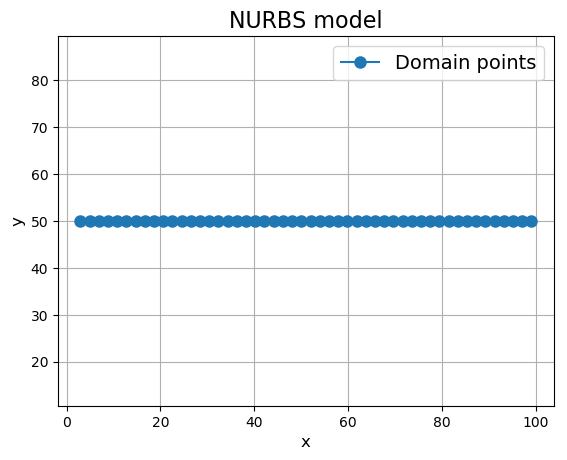

PyObject <matplotlib.legend.Legend object at 0x7f28b49b2990>

In [21]:
# Graphics
nurbs2D.mostra_geo(crv)
nurbs2D.plot(collocCoord[:,1],collocCoord[:,2],marker="s",markersize=10,linestyle="none",color="blue",label = "Physical points (Nodes)")
nurbs2D.plot(PONTOS_int[:,2],PONTOS_int[:,3],marker="o",markersize=8,label="Domain points")
nurbs2D.axis("equal")
nurbs2D.grid(1)
nurbs2D.PyPlot.xlabel("x",fontsize="12.0")
nurbs2D.PyPlot.ylabel("y",fontsize="12.0")
nurbs2D.title("NURBS model",fontsize="16.0")
nurbs2D.legend(fontsize="14.0",loc="upper right")

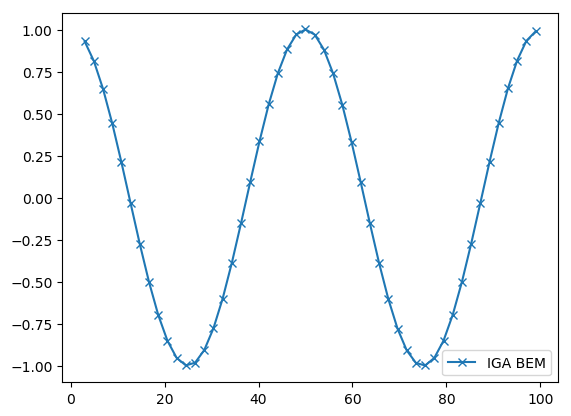

PyObject <matplotlib.legend.Legend object at 0x7f28b4b74fd0>

In [22]:
# Plot domain point solution and analytical solution
nurbs2D.plot(PONTOS_int[:,2],phi_closed(PONTOS_int[:,2],n,L,c),label="Analytical solution, mode n=$(n), F = $(F_closed(n,L,c)/(2*pi)) Hz")
nurbs2D.plot(PONTOS_int[:,2],real(phi_pint),marker="x",label="IGA BEM")
nurbs2D.legend()